<a href="https://colab.research.google.com/github/kota-mizu/smbc_price_forecasting/blob/main/inference_notebook/Inf_0609_21%3A49.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://signate.jp/competitions/1634



In [737]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# セットアップ

In [738]:
!pip install holidays

In [739]:
# ライブラリのインポート
import os, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays

from IPython.display import display
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score



warnings.filterwarnings("ignore")

# 日本語フォントを簡単に使う
!pip -q install japanize-matplotlib
import japanize_matplotlib

# データの読み込み

In [740]:
data_path = '/content/drive/MyDrive/signate_smbc/'
submission_path = '/content/drive/MyDrive/signate_smbc/submission/'

In [741]:
train_raw_df  = pd.read_csv(data_path + 'train.csv')
test_raw_df   = pd.read_csv(data_path + 'test.csv')
sample_submission_df = pd.read_csv(data_path + 'sample_submit.csv', header=None)  # header 無し
feature_description = pd.read_csv(data_path + 'feature_description.csv', index_col = 0)

# 前処理
 目的: データをモデルが扱える状態に整える
 - 欠損値の補完
 - データ型の変換 (例: time列をdatetimeへ)
 - カテゴリ変数の基本的なエンコーディング (One-Hotなど)
 ★この処理は関数化するのが望ましい (例: def preprocess(df):)

In [742]:
#前処理用にコピーを作成
train_df = train_raw_df.copy()
test_df = test_raw_df.copy()

In [743]:
train_df.head()

,time,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,...,seville_wind_deg,seville_rain_1h,seville_rain_3h,seville_snow_3h,seville_clouds_all,seville_weather_id,seville_weather_main,seville_weather_description,seville_weather_icon,price_actual
0,2015-01-02 00:00:00+01:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,...,33,0.0,0.0,0.0,0,800,clear,sky is clear,01n,64.02
1,2015-01-02 01:00:00+01:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,...,33,0.0,0.0,0.0,0,800,clear,sky is clear,01n,58.46
2,2015-01-02 02:00:00+01:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,...,44,0.0,0.0,0.0,0,800,clear,sky is clear,01n,54.70
3,2015-01-02 03:00:00+01:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,...,44,0.0,0.0,0.0,0,800,clear,sky is clear,01n,54.91
4,2015-01-02 04:00:00+01:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,...,44,0.0,0.0,0.0,0,800,clear,sky is clear,01n,53.07


In [744]:
# 前処理の対象の特徴量をリストアップ
train_selected = train_df.copy()
test_selected = test_df.copy()

風力ポテンシャル関数


In [745]:
# def add_wind_potential_features(df):
#     """
#     DataFrameに5都市それぞれの風力ポテンシャル特徴量を追加する関数。
#     """
#     # 元のDataFrameを変更しないようにコピーを作成
#     df_processed = df.copy()

#     # 都市名のリスト
#     cities = ['valencia', 'madrid', 'bilbao', 'barcelona', 'seville']

#     # 削除対象となる元のカラム名を格納するリスト
#     original_wind_cols_to_drop = []

#     # 各都市についてループ処理
#     for city in cities:
#         wind_speed_col = f'{city}_wind_speed'
#         wind_potential_col = f'{city}_wind_potential'

#         if wind_speed_col in df_processed.columns:
#             # 新しい特徴量を作成
#             df_processed[wind_potential_col] = df_processed[wind_speed_col] ** 3
#             # 削除リストに元のカラム名を追加
#             original_wind_cols_to_drop.append(wind_speed_col)
#         else:
#             print(f"警告: カラム '{wind_speed_col}' が見つかりませんでした。")

#     # ループの後に、リストアップしたカラムをまとめて削除
#     if original_wind_cols_to_drop:
#         df_processed.drop(columns=original_wind_cols_to_drop, inplace=True)

#     return df_processed

# # 学習データに適用
# train_selected = add_wind_potential_features(train_selected)

# # テストデータに適用
# test_selected = add_wind_potential_features(test_selected)

再生可能エネルギー以外の不足分関数

In [746]:
# def add_renewable_shortfall_feature(df):
#     """
#     DataFrameに「総再生可能エネルギー発電量では賄いきれない需要」
#     を示す 'renewable_shortfall' 特徴量を追加する関数。

#     Args:
#         df (pd.DataFrame): 処理対象のDataFrame。
#                            'total_load_actual' と各種発電量カラムを含む必要がある。

#     Returns:
#         pd.DataFrame: 'renewable_shortfall' カラムが追加された新しいDataFrame。
#     """
#     # 元のDataFrameを変更しないようにコピーを作成
#     df_processed = df.copy()

#     # 再生可能エネルギーに該当するカラムのリストを定義
#     renewable_cols = [
#         'generation_biomass',
#         'generation_hydro_run_of_river_and_poundage',
#         'generation_hydro_water_reservoir',
#         'generation_other_renewable',
#         'generation_solar',
#         'generation_waste',
#         'generation_wind_onshore'
#     ]

#     # DataFrameに存在する再エネカラムのみを対象にする
#     existing_renewable_cols = [col for col in renewable_cols if col in df_processed.columns]

#     # 1. 各行の総再生可能エネルギー発電量を計算
#     df_processed['total_renewable_generation'] = df_processed[existing_renewable_cols].sum(axis=1)

#     # 2. 「総需要」から「総再エネ発電量」を引いて、賄いきれない需要（不足分）を計算
#     df_processed['renewable_shortfall'] = df_processed['total_load_actual'] - df_processed['total_renewable_generation']

#     # 3. 不足分がマイナスになる場合（再エネが需要を上回る場合）は0にクリップする
#     df_processed['renewable_shortfall'] = df_processed['renewable_shortfall'].clip(lower=0)

#     # 中間的に作成した総再エネ発電量の列は不要なので削除
#     df_processed.drop(columns=['total_renewable_generation'], inplace=True)

#     return df_processed

# train_selected = add_renewable_shortfall_feature(train_selected)
# test_selected = add_renewable_shortfall_feature(test_selected)

再生可能エネルギー発電量比率関数

In [747]:
def add_renewable_share_feature(df):
    """
    DataFrameに「総発電量に占める、再生可能エネルギー発電量の比率」
    を示す 'renewable_share' 特徴量を追加する関数。

    Args:
        df (pd.DataFrame): 処理対象のDataFrame。
                           各種発電量カラムを含む必要がある。

    Returns:
        pd.DataFrame: 'renewable_share' カラムが追加された新しいDataFrame。
    """
    # 元のDataFrameを変更しないようにコピーを作成
    df_processed = df.copy()

    # --- 1. 各発電カテゴリのカラムを定義 ---

    # 再生可能エネルギーに該当するカラム
    renewable_cols = [
        'generation_biomass',
        'generation_hydro_run_of_river_and_poundage',
        'generation_hydro_water_reservoir',
        'generation_other_renewable',
        'generation_solar',
        'generation_waste',
        'generation_wind_onshore'
    ]

    # 「発電量（供給）」と見なせる全てのカラム
    # 揚水発電の「消費」は供給ではないため除外する
    all_supply_cols = [col for col in df_processed.columns if 'generation' in col and 'consumption' not in col]

    # DataFrameに存在するカラムのみを対象にする
    existing_renewable_cols = [col for col in renewable_cols if col in df_processed.columns]

    # --- 2. 各発電量を計算 ---

    # 総再生可能エネルギー発電量を計算
    df_processed['total_renewable_generation'] = df_processed[existing_renewable_cols].sum(axis=1)

    # 総発電量（総供給量）を計算
    df_processed['total_generation'] = df_processed[all_supply_cols].sum(axis=1)

    # --- 3. 比率を計算 ---

    # 「総再エネ発電量」を「総発電量」で割り、比率を計算
    df_processed['renewable_share'] = df_processed['total_renewable_generation'] / df_processed['total_generation']

    # 0除算によって発生した無限大(inf)や欠損値(NaN)を0で埋める
    df_processed['renewable_share'].replace([np.inf, -np.inf], np.nan, inplace=True)
    df_processed['renewable_share'].fillna(0, inplace=True)

    # 中間的に作成した列は不要なので削除
    df_processed.drop(columns=['total_renewable_generation', 'total_generation'], inplace=True)

    return df_processed

train_selected = add_renewable_share_feature(train_selected)
test_selected = add_renewable_share_feature(test_selected)

再エネ比率の方が再エネで賄えない消費量よりもスコアは改善

In [748]:
train_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 93 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         26280 non-null  object 
 1   generation_biomass                           26259 non-null  float64
 2   generation_fossil_brown_coal/lignite         26260 non-null  float64
 3   generation_fossil_gas                        26260 non-null  float64
 4   generation_fossil_hard_coal                  26260 non-null  float64
 5   generation_fossil_oil                        26259 non-null  float64
 6   generation_hydro_pumped_storage_consumption  26259 non-null  float64
 7   generation_hydro_run_of_river_and_poundage   26259 non-null  float64
 8   generation_hydro_water_reservoir             26260 non-null  float64
 9   generation_nuclear                           26261 non-null  float64
 10

In [749]:
#この先の処理で使用するカラムの選択
use_cols = [
    "time",
    'total_load_actual',
    'generation_solar',
    'generation_wind_onshore',
    'generation_hydro_run_of_river_and_poundage',
    'generation_fossil_gas',
    'generation_fossil_hard_coal',
    'generation_fossil_oil',
    'generation_fossil_brown_coal/lignite',
    "madrid_temp",
    "valencia_temp",
    "bilbao_temp",
    "barcelona_temp",
    "seville_temp",
    "madrid_wind_speed",
    "valencia_wind_speed",
    "bilbao_wind_speed",
    "barcelona_wind_speed",
    "seville_wind_speed",
    "renewable_share",
    "madrid_clouds_all",
    "valencia_clouds_all",
    "bilbao_clouds_all",
    "barcelona_clouds_all",
    "seville_clouds_all",
    "madrid_snow_3h",
    "valencia_snow_3h",
    "bilbao_snow_3h",
    "barcelona_snow_3h", #barcelonaは雪が降っていない
    "seville_snow_3h", #train
    "price_actual"
]

train_selected = train_selected[use_cols]
test_selected = test_selected[use_cols[:-1]]

In [750]:
# 欠損値補完
train_selected.ffill(inplace=True)
test_selected.ffill(inplace=True)

In [751]:
# 標準化するカラムの選択
scale_cols = [
     'total_load_actual',
    'generation_solar',
    'generation_wind_onshore',
    'generation_hydro_run_of_river_and_poundage',
    'generation_fossil_gas',
    'generation_fossil_hard_coal',
    'generation_fossil_oil',
    'generation_fossil_brown_coal/lignite',
    "madrid_wind_speed",
    "valencia_wind_speed",
    "bilbao_wind_speed",
    "barcelona_wind_speed",
    "seville_wind_speed",
    ]
# OKのデータフレームで作成
train_ok = train_selected.copy()

In [752]:
# OK 版：行 t 以前だけで平均・標準偏差を更新しながら標準化（expanding().mean()/std() を使う）
for col in scale_cols:
    # 平均と標準偏差を逐次更新
    train_ok[f"{col}_mean_to_t"] = train_ok[col].expanding().mean()
    train_ok[f"{col}_std_to_t"]  = train_ok[col].expanding().std(ddof=0)

    # 0除算を避けるため std==0 の行は NaN に
    train_ok[f"{col}_scaled"] = (
        (train_ok[col] - train_ok[f"{col}_mean_to_t"]) /
        train_ok[f"{col}_std_to_t"]
    )



In [753]:
train_ok.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26280 entries, 0 to 26279
Data columns (total 70 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   time                                                  26280 non-null  object 
 1   total_load_actual                                     26280 non-null  float64
 2   generation_solar                                      26280 non-null  float64
 3   generation_wind_onshore                               26280 non-null  float64
 4   generation_hydro_run_of_river_and_poundage            26280 non-null  float64
 5   generation_fossil_gas                                 26280 non-null  float64
 6   generation_fossil_hard_coal                           26280 non-null  float64
 7   generation_fossil_oil                                 26280 non-null  float64
 8   generation_fossil_brown_coal/lignite                  26

In [754]:
print("◆ OK（リークなし）")
display(train_ok[[*(f"{c}_scaled" for c in scale_cols) ]].head())

◆ OK（リークなし）


,total_load_actual_scaled,generation_solar_scaled,generation_wind_onshore_scaled,generation_hydro_run_of_river_and_poundage_scaled,generation_fossil_gas_scaled,generation_fossil_hard_coal_scaled,generation_fossil_oil_scaled,generation_fossil_brown_coal/lignite_scaled,madrid_wind_speed_scaled,valencia_wind_speed_scaled,bilbao_wind_speed_scaled,barcelona_wind_speed_scaled,seville_wind_speed_scaled
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1.000000,1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,NaN,NaN,-1.000000,NaN,NaN
2,-1.311200,0.707107,-1.197652,-1.192166,-0.666844,-1.363200,-0.925820,-1.397001,NaN,NaN,-0.707107,NaN,1.414214
3,-1.379864,0.577350,-1.156156,-1.207589,-1.549117,-1.637686,0.390567,-1.727549,NaN,NaN,-0.577350,NaN,1.000000
4,-1.345247,-1.984572,-1.275557,-0.885225,-1.380235,-1.544575,-1.207020,-1.729614,NaN,NaN,-0.500000,NaN,0.816497


In [755]:
test_ok = test_selected.copy()
for col in scale_cols:
    mu_train = train_ok[f"{col}_mean_to_t"].iloc[-1]
    std_train = train_ok[f"{col}_std_to_t"].iloc[-1]
    test_ok[f"{col}_scaled"] = (test_ok[col] - mu_train) / std_train

In [756]:
#標準偏差と平均と元データを消す
std_mean_cols = [c for c in train_ok.columns if c.endswith("_std_to_t") or c.endswith("_mean_to_t")]
drop_cols = std_mean_cols + scale_cols
train_ok.drop(columns=drop_cols, inplace=True)

In [757]:
display(train_ok)

,time,madrid_temp,valencia_temp,bilbao_temp,barcelona_temp,seville_temp,renewable_share,madrid_clouds_all,valencia_clouds_all,bilbao_clouds_all,...,generation_hydro_run_of_river_and_poundage_scaled,generation_fossil_gas_scaled,generation_fossil_hard_coal_scaled,generation_fossil_oil_scaled,generation_fossil_brown_coal/lignite_scaled,madrid_wind_speed_scaled,valencia_wind_speed_scaled,bilbao_wind_speed_scaled,barcelona_wind_speed_scaled,seville_wind_speed_scaled
0,2015-01-02 00:00:00+01:00,267.129,271.229,273.474656,282.779,276.529,0.368519,0,0,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-02 01:00:00+01:00,267.129,271.229,272.502500,282.779,276.529,0.346569,0,0,16,...,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,NaN,NaN,-1.000000,NaN,NaN
2,2015-01-02 02:00:00+01:00,266.389,270.664,272.732344,281.864,276.314,0.334426,0,0,0,...,-1.192166,-0.666844,-1.363200,-0.925820,-1.397001,NaN,NaN,-0.707107,NaN,1.414214
3,2015-01-02 03:00:00+01:00,266.389,270.664,272.060656,281.864,276.314,0.325464,0,0,0,...,-1.207589,-1.549117,-1.637686,0.390567,-1.727549,NaN,NaN,-0.577350,NaN,1.000000
4,2015-01-02 04:00:00+01:00,266.389,270.664,272.093000,281.864,276.314,0.322058,0,0,10,...,-0.885225,-1.380235,-1.544575,-1.207020,-1.729614,NaN,NaN,-0.500000,NaN,0.816497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26275,2017-12-31 19:00:00+01:00,282.910,290.150,281.670000,287.150,289.940,0.535022,90,20,75,...,0.681146,-0.704249,-1.680952,-1.774078,-1.314554,1.799861,1.266087,0.080014,1.056217,0.856574
26276,2017-12-31 20:00:00+01:00,281.960,290.150,281.180000,288.270,289.330,0.532444,40,40,40,...,0.735253,-0.722716,-1.673928,-1.551847,-1.314486,2.303325,1.636907,0.080012,1.551859,1.400125
26277,2017-12-31 21:00:00+01:00,281.810,289.150,281.680000,288.150,288.940,0.529590,0,40,20,...,0.729819,-0.745145,-1.676272,-1.403685,-1.314418,0.792204,1.265921,-0.457285,2.047386,0.312879
26278,2017-12-31 22:00:00+01:00,281.580,290.150,280.690000,287.150,288.540,0.516343,0,40,20,...,0.613424,-0.672051,-1.735304,-1.459128,-1.314349,1.799464,2.007567,-0.457275,0.560274,-0.774355


# 特徴量エンジニアリング
 目的: モデルの精度を向上させるための新しい特徴量を作成する
 - 時間特徴量の作成 (hour, dayofweek, is_holidayなど)
 - 気象特徴量の作成 (temp_deviationなど)
 - ラグ特徴量、移動統計量の作成
 - 交互作用特徴量の作成
 ★この処理も特徴量の種類ごとに関数化するのが望ましい (例: def create_time_features(df):)

In [758]:
train_df = train_ok.copy()
test_df = test_ok.copy()

In [759]:
def create_city_temp_deviation_features(df):
    """
    DataFrameに5都市それぞれの気温偏差特徴量を追加する関数。
    """
    # 元のDataFrameを変更しないようにコピーを作成
    df_processed = df.copy()

    # 都市名のリスト
    cities = ['valencia', 'madrid', 'bilbao', 'barcelona', 'seville']

    # 快適温度を定義（この値は調整可能です）
    COMFORT_TEMP = 17.5

    print(f"各都市の「快適温度({COMFORT_TEMP}℃)からの差」を特徴量として作成します...")

    # 各都市についてループ処理
    for city in cities:
        # 関連するカラム名を定義
        temp_k_col = f'{city}_temp'          # 元のケルビン温度カラム
        temp_c_col = f'{city}_temp_c'        # 新しく作成する摂氏温度カラム
        deviation_col = f'{city}_temp_deviation' # 最終的に作成する偏差特徴量カラム

        # 1. ケルビンから摂氏(℃)に変換
        df_processed[temp_c_col] = df_processed[temp_k_col] - 273.15

        # 2. 快適温度との差の絶対値を計算
        df_processed[deviation_col] = (df_processed[temp_c_col] - COMFORT_TEMP).abs()

        # 3. temp_k_colとtemp_c_colを削除
        df_processed.drop(columns=[temp_k_col, temp_c_col], inplace=True)

    print("特徴量の作成が完了しました。")
    return df_processed

# --- 関数を使って train_ok と test_ok の両方に特徴量を追加 ---
train_df = create_city_temp_deviation_features(train_df)
test_df = create_city_temp_deviation_features(test_df)


# --- 結果の確認 ---
# 作成された新しい特徴量のカラム名リスト
new_cols = [f'{city}_temp_deviation' for city in ['valencia', 'madrid', 'bilbao', 'barcelona', 'seville']]

print("\n--- 作成された新しい特徴量の確認 (train_df_featured) ---")
print(train_df[new_cols].head())

# print("\n--- 作成された新しい特徴量の確認 (test_df_featured) ---")
# print(test_df_featured[new_cols].head())

各都市の「快適温度(17.5℃)からの差」を特徴量として作成します...
特徴量の作成が完了しました。
各都市の「快適温度(17.5℃)からの差」を特徴量として作成します...
特徴量の作成が完了しました。

--- 作成された新しい特徴量の確認 (train_df_featured) ---
   valencia_temp_deviation  madrid_temp_deviation  bilbao_temp_deviation  \
0                   19.421                 23.521              17.175344   
1                   19.421                 23.521              18.147500   
2                   19.986                 24.261              17.917656   
3                   19.986                 24.261              18.589344   
4                   19.986                 24.261              18.557000   

   barcelona_temp_deviation  seville_temp_deviation  
0                     7.871                  14.121  
1                     7.871                  14.121  
2                     8.786                  14.336  
3                     8.786                  14.336  
4                     8.786                  14.336  


In [760]:
def preprocess_dataframe(df_raw):
    """
    生のDataFrameを受け取り、日時インデックスの設定などの基本的な前処理を行う関数。
    """
    if df_raw is None:
        return None

    # 元のデータを変更しないためにコピーを作成
    df = df_raw.copy()

    # 日時変換プロセス、timeをindexに
    if 'time' in df.columns:
        datetime_part_str = df['time'].str[:-6]
        # datetime_part_str = df.index.strftime("%Y-%m-%d %H:%M:%S")
        naive_datetime = pd.to_datetime(datetime_part_str)
        df['time'] = naive_datetime.dt.tz_localize('UTC').dt.tz_convert('Europe/Madrid')
        df.set_index('time', inplace=True)

    # 他にも共通の前処理があれば、ここに追加していく
    # 例: df.ffill(inplace=True)

    return df

# --- 祝日フラグ追加の関数も定義 ---
import holidays
def add_holiday_feature(df, holiday_years):
    """
    DataFrameにスペインの祝日フラグ特徴量を追加する関数。
    """
    if df is None:
        return None
    df_processed = df.copy()
    es_holidays = holidays.Spain(years=holiday_years)
    df_processed['is_holiday'] = df_processed.index.to_series().dt.date.isin(es_holidays).astype(int)
    return df_processed

In [761]:
# 祝日フラグを追加する

if train_df is not None:
    # 1. まず基本的な前処理を適用
    train_df = preprocess_dataframe(train_df)
    test_df = preprocess_dataframe(test_df)
    print("基本的な前処理が完了しました。")

    # 2. 祝日判定の対象年を計算
    train_years = train_df.index.year.unique()
    test_years = test_df.index.year.unique()
    all_unique_years = sorted(list(set(train_years) | set(test_years)))
    print(f"対象年: {all_unique_years}")

    # 3. 祝日フラグを追加
    train_df = add_holiday_feature(train_df, holiday_years=all_unique_years)
    test_df = add_holiday_feature(test_df, holiday_years=all_unique_years)
    print("祝日フラグの追加が完了しました。")

    # 4. 結果を確認
    print("\n--- 'is_holiday'列が追加されたDataFrameの確認 ---")
    print(train_df[['is_holiday']].head())
else:
    print("データが読み込まれていないため、処理を実行できません。最初のセルをまず実行してください。")

基本的な前処理が完了しました。
対象年: [2015, 2016, 2017, 2018, 2019]
祝日フラグの追加が完了しました。

--- 'is_holiday'列が追加されたDataFrameの確認 ---
                           is_holiday
time                                 
2015-01-02 01:00:00+01:00           0
2015-01-02 02:00:00+01:00           0
2015-01-02 03:00:00+01:00           0
2015-01-02 04:00:00+01:00           0
2015-01-02 05:00:00+01:00           0


*   hour: 時 (0-23)
*  dayofweek: 曜日 (月曜日=0, 火曜日=1, ..., 日曜日=6)
*  dayofyear: 年の日 (1-366)
*  month: 月 (1-12)

In [762]:
def create_time_features(df):
    """
    DataFrameのDatetimeIndexから時間に関する特徴量を作成する関数。
    """
    # 元のDataFrameを変更しないようにコピーを作成
    df_processed = df.copy()

    # インデックスをdatetime型に変換する際に、まずUTCとして解釈させる
    # ★★★ ここを修正 ★★★
    df_processed.index = pd.to_datetime(df_processed.index, errors='coerce', utc=True)

    # UTCに設定されたインデックスを、目的のタイムゾーンに変換する
    # この行は正しく動作するようになります
    df_processed.index = df_processed.index.tz_convert("Etc/GMT-1")

    # 時間に関する特徴量を追加
    df_processed['hour'] = df_processed.index.hour
    df_processed['dayofweek'] = df_processed.index.dayofweek
    # df_processed['dayofyear'] = df_processed.index.dayofyear
    df_processed['month'] = df_processed.index.month

    return df_processed

# --- 関数を使って train_df と test_df を一度に処理 ---
try:
    train_df = create_time_features(train_df)
    test_df = create_time_features(test_df)
    print("時間特徴量の作成が完了しました。")
    print(train_df[['hour', 'dayofweek', 'month']].head())
except Exception as e:
    print(f"エラーが発生しました: {e}")


時間特徴量の作成が完了しました。
                           hour  dayofweek  month
time                                             
2015-01-02 01:00:00+01:00     1          4      1
2015-01-02 02:00:00+01:00     2          4      1
2015-01-02 03:00:00+01:00     3          4      1
2015-01-02 04:00:00+01:00     4          4      1
2015-01-02 05:00:00+01:00     5          4      1


In [763]:
# def add_snow_flag_features(df, drop_original=True):
#     """
#     DataFrameに5都市それぞれの降雪フラグ特徴量を追加する関数。
#     snow_3h > 0 なら 1、そうでなければ 0 を設定します。

#     Args:
#         df (pd.DataFrame): 処理対象のDataFrame。
#                            各都市の '_snow_3h' カラムを含む必要がある。
#         drop_original (bool): Trueの場合、処理後に元の'_snow_3h'カラムを削除する。
#                               デフォルトは True。

#     Returns:
#         pd.DataFrame: '_is_snowing' カラムが追加された新しいDataFrame。
#     """
#     # 元のDataFrameを変更しないようにコピーを作成
#     df_processed = df.copy()

#     # 都市名のリスト
#     cities = ['valencia', 'madrid', 'bilbao', 'barcelona', 'seville']

#     # 削除対象となる元のカラム名を格納するリスト
#     original_snow_cols_to_drop = []

#     print("降雪フラグ特徴量を作成します...")

#     # 各都市についてループ処理
#     for city in cities:
#         # 関連するカラム名を定義
#         snow_col = f'{city}_snow_3h'
#         is_snowing_col = f'{city}_is_snowing'

#         # カラムが存在するかチェック
#         if snow_col in df_processed.columns:
#             # 新しいフラグ特徴量を作成 (snow_3h > 0 であれば True (1) になる)
#             df_processed[is_snowing_col] = (df_processed[snow_col] > 0).astype(int)

#             # 元のカラムを削除する場合、リストに追加
#             if drop_original:
#                 original_snow_cols_to_drop.append(snow_col)
#         else:
#             print(f"警告: カラム '{snow_col}' が見つかりませんでした。スキップします。")

#     # ループの後に、リストアップしたカラムをまとめて削除
#     if drop_original and original_snow_cols_to_drop:
#         df_processed.drop(columns=original_snow_cols_to_drop, inplace=True)
#         print("元の降雪量カラムを削除しました。")

#     print("特徴量の作成が完了しました。")
#     return df_processed

# train_df = add_snow_flag_features(train_df)
# test_df = add_snow_flag_features(test_df)

In [764]:
def add_solar_potential_features(df, drop_original=True): # ★デフォルト値を True に変更
    """
    DataFrameに5都市それぞれの日照ポテンシャル特徴量を追加する関数。
    デフォルトでは、処理後に元の'_clouds_all'カラムを削除します。

    Args:
        df (pd.DataFrame): 処理対象のDataFrame。
                           各都市の '_clouds_all' カラムを含む必要がある。
        drop_original (bool): Trueの場合、元の'_clouds_all'カラムを削除する。
                              デフォルトは True。

    Returns:
        pd.DataFrame: '_solar_potential' カラムが追加された新しいDataFrame。
    """
    # 元のDataFrameを変更しないようにコピーを作成
    df_processed = df.copy()

    # 都市名のリスト
    cities = ['valencia', 'madrid', 'bilbao', 'barcelona', 'seville']

    # 削除対象となる元のカラム名を格納するリスト
    original_cloud_cols_to_drop = []

    # 各都市についてループ処理
    for city in cities:
        cloud_col = f'{city}_clouds_all'
        potential_col = f'{city}_solar_potential'

        # カラムが存在するかチェック
        if cloud_col in df_processed.columns:
            # 新しい特徴量を作成 (100 - 雲量)
            df_processed[potential_col] = 100 - df_processed[cloud_col]

            # 元のカラムを削除する場合、リストに追加
            if drop_original:
                original_cloud_cols_to_drop.append(cloud_col)
        else:
            print(f"警告: カラム '{cloud_col}' が見つかりませんでした。スキップします。")

    # ループの後に、リストアップしたカラムをまとめて削除
    if drop_original and original_cloud_cols_to_drop:
        df_processed.drop(columns=original_cloud_cols_to_drop, inplace=True)

    return df_processed

train_df = add_solar_potential_features(train_df)
test_df = add_solar_potential_features(test_df)

solar_potentialを入れると0.04スコアが悪くなった

In [765]:
def add_day_off_feature(df):
    """
    週末または祝日であるかを示す 'is_day_off' フラグを作成する関数。
    """
    if df is None or 'dayofweek' not in df.columns or 'is_holiday' not in df.columns:
        print("必要な 'dayofweek' または 'is_holiday' カラムが存在しません。")
        return df

    df_processed = df.copy()

    # dayofweekが5以上（土日）または is_holidayが1（祝日）の条件
    is_off_condition = (df_processed['dayofweek'] >= 5) | (df_processed['is_holiday'] == 1)

    # 条件に合致すれば1、そうでなければ0を新しい列に設定
    df_processed['is_day_off'] = is_off_condition.astype(int)

    df_processed.drop(columns = ['is_holiday'], inplace = True)

    return df_processed

train_df = add_day_off_feature(train_df)
test_df = add_day_off_feature(test_df)

In [766]:
# def add_cyclical_features(df):
#     """
#     時間に関する特徴量にsin/cos変換を適用し、周期性を表現する特徴量を追加する関数。
#     この関数は、add_time_features()が実行された後のDataFrameを想定しています。
#     """
#     if df is None:
#         return None

#     df_processed = df.copy()

#     print("sin/cos変換による周期性特徴量を作成中...")

#     # 1日の周期（24時間）
#     df_processed['hour_sin'] = np.sin(2 * np.pi * df_processed['hour'] / 24.0)
#     df_processed['hour_cos'] = np.cos(2 * np.pi * df_processed['hour'] / 24.0)

#     # 1年の周期（12ヶ月）
#     df_processed['month_sin'] = np.sin(2 * np.pi * df_processed['month'] / 12.0)
#     df_processed['month_cos'] = np.cos(2 * np.pi * df_processed['month'] / 12.0)

#     return df_processed

# train_df = add_cyclical_features(train_df)
# test_df = add_cyclical_features(test_df)

sin/cos変換はイマイチみたい


In [767]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26280 entries, 2015-01-02 01:00:00+01:00 to 2018-01-01 00:00:00+01:00
Data columns (total 34 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   renewable_share                                    26280 non-null  float64
 1   madrid_snow_3h                                     26280 non-null  float64
 2   valencia_snow_3h                                   26280 non-null  float64
 3   bilbao_snow_3h                                     26280 non-null  float64
 4   barcelona_snow_3h                                  26280 non-null  float64
 5   seville_snow_3h                                    26280 non-null  float64
 6   price_actual                                       26280 non-null  float64
 7   total_load_actual_scaled                           26279 non-null  float64
 8   generation_solar_scaled                

# モデル学習と検証
 - 使用する特徴量の選定
 - 学習データと検証データの分割
 - モデルの定義、学習、予測
 - 評価指標の計算

## Cross validation（単純に時間で分割する方法）

In [768]:

from sklearn.model_selection import KFold # TimeSeriesSplitの代わりにKFoldをインポート
from sklearn.metrics import root_mean_squared_error
# --- モデル学習の準備 ---

# 特徴量と目的変数を定義
# あなたのコードから、使用する特徴量リストを特定します
exclude_cols = ["price_actual"]
feature_cols = [c for c in train_df.columns if c not in exclude_cols]
categorical_cols = ['is_day_off', "hour", "month", "dayofweek"]
# カテゴリカル指定する列がfeature_colsに存在することを確認
categorical_features = [col for col in categorical_cols if col in feature_cols]

X = train_df[feature_cols]
y = train_df['price_actual']
X_test = test_df[feature_cols]

# 欠損値を埋める（CV前に全体に適用）
X.ffill(inplace=True)
X.bfill(inplace=True)
X_test.ffill(inplace=True)
X_test.bfill(inplace=True)


# --- KFoldによるクロスバリデーション ---
print("\n--- KFold Cross-Validationを開始します ---")

# 5分割し、データをシャッフルするKFoldオブジェクトを作成
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# 各Foldのスコアと、テストデータに対する予測を格納するリスト
oof_rmse_scores = []
test_predictions = []
best_iterations = [] # ★ 最適な学習回数を記録するリストを追加

for i, (train_index, val_index) in enumerate(kf.split(X, y)):
    print(f"\n--- Fold {i+1}/{n_splits} ---")

    # データを学習用と検証用に分割
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # モデルを初期化（Foldごとに新しいモデルを使うことが重要）
    model_lgbm = lgb.LGBMRegressor(
        objective='regression_l1',
        random_state=42 + i, # Foldごとに乱数を変える
        n_estimators=1000,
        # learning_rateやnum_leavesなどもここに設定
    )

    # モデルを学習
    model_lgbm.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        categorical_feature=categorical_features,
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)] # CV中はログを非表示に
    )

    # このFoldでの検証データに対する予測と評価
    val_preds = model_lgbm.predict(X_val)
    score = root_mean_squared_error(y_val, val_preds)
    oof_rmse_scores.append(score)
    print(f"Fold {i+1} RMSE: {score:.4f}")

    # ★ このFoldでの最適な学習回数をリストに追加
    best_iter = model_lgbm.best_iteration_
    print(f"Fold {i+1} Best Iteration: {best_iter}")
    best_iterations.append(best_iter)

    # このFoldで学習したモデルでテストデータを予測し、結果を保存
    test_preds = model_lgbm.predict(X_test)
    test_predictions.append(test_preds)

# --- 結果の集計 ---
print("\n--- Cross-Validation Results ---")
print(f"RMSE scores for each fold: {np.round(oof_rmse_scores, 4)}")
print(f"Average RMSE: {np.mean(oof_rmse_scores):.4f}")
print(f"Std Dev of RMSE: {np.std(oof_rmse_scores):.4f}")


# --- 最終的なテストデータに対する予測の作成 ---
# 各Foldで予測した結果の平均を取ることで、より頑健な予測値を作成（アンサンブル効果）
k_fold_final_test_predictions = np.mean(test_predictions, axis=0)

print("\n最終的なテストデータへの予測値（最初の5件）:")
print(k_fold_final_test_predictions[:5])


--- KFold Cross-Validationを開始します ---

--- Fold 1/5 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5310
[LightGBM] [Info] Number of data points in the train set: 21024, number of used features: 29
[LightGBM] [Info] Start training from score 55.990002
Fold 1 RMSE: 4.2940
Fold 1 Best Iteration: 1000

--- Fold 2/5 ---
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5321
[LightGBM] [Info] Number of data points in the train set: 21024, number of used features: 29
[LightGBM] [Info] Start training from score 55.930000
Fold 2 RMSE: 4.3772
Fold 2 Best Iteration: 1000

--- Fold 3/5 --

--- Cross-Validation Results ---
* RMSE scores for each fold: [5.3755 5.3622 5.4332 5.5545 5.2193]
*Average RMSE: 5.3889
*Std Dev of RMSE: 0.1087

--- Cross-Validation Results ---
* RMSE scores for each fold: [5.5851 5.6754 5.5604]
*Average RMSE: 5.6070
*Std Dev of RMSE: 0.0494

--- Cross-Validation Results --- wind_speedを適用
* RMSE scores for each fold: [4.4903 4.5867 4.4224 4.4643 4.5374]
*Average RMSE: 4.5002
*Std Dev of RMSE: 0.0571


### Cross Validation （時系列に沿って行う方法）

In [769]:
from sklearn.metrics import root_mean_squared_error
from dateutil.relativedelta import relativedelta # 日付計算のため

# --- 1. モデル学習の準備 ---

# 特徴量と目的変数を定義
exclude_cols = ["price_actual"]
feature_cols = [c for c in train_df.columns if c not in exclude_cols]
categorical_cols = ['is_day_off', "hour", "month", "dayofweek"]

X = train_df[feature_cols]
y = train_df['price_actual']
# X_test も同様に準備されていると仮定
X_test = test_df[feature_cols]

# 欠損値を埋める
X.ffill(inplace=True); X.bfill(inplace=True)
X_test.ffill(inplace=True); X_test.bfill(inplace=True)


# --- 2. 拡張ウィンドウによるクロスバリデーション ---
print("\n--- Expanding Window Cross-Validationを開始します ---")

# 各Foldの学習終了日と検証終了日をリストとして定義
split_points = [
    ("2015-12-31", "2016-06-30"),
    ("2016-06-30", "2016-12-31"),
    ("2016-12-31", "2017-06-30"),
    ("2017-06-30", "2017-12-31")
    ]

# 各Foldのスコアと、テストデータに対する予測を格納するリスト
oof_rmse_scores = []
test_predictions = []
best_iterations = [] # ★ 最適な学習回数を記録するリストを追加


# タイムゾーンエラーを回避するため、インデックスをUTCに変換して処理
X_utc = X.tz_convert('UTC')
y_utc = y.tz_convert('UTC')

for i, (train_end_str, val_end_str) in enumerate(split_points):
    print(f"\n--- Fold {i+1}/{len(split_points)} ---")

    # 学習開始日は常にデータの最初
    train_start = X_utc.index.min()

    # スライス用に、文字列の日付をUTCのタイムスタンプに変換
    train_end = pd.to_datetime(train_end_str).tz_localize('UTC')
    val_start = train_end + pd.Timedelta(days=1) # 検証は学習の翌日から
    val_end = pd.to_datetime(val_end_str).tz_localize('UTC')

    # UTCに変換したデータからスライスして学習・検証データを準備
    X_train, X_val = X_utc.loc[train_start:train_end], X_utc.loc[val_start:val_end]
    y_train, y_val = y_utc.loc[train_start:train_end], y_utc.loc[val_start:val_end]

    print(f"Training: {X_train.index.min().date()} to {X_train.index.max().date()} ({len(X_train)} rows)")
    print(f"Validation: {X_val.index.min().date()} to {X_val.index.max().date()} ({len(X_val)} rows)")

    # モデルを初期化
    model_lgbm = lgb.LGBMRegressor(
        objective='regression_l1',
        random_state=42 + i,
        n_estimators=1000,
    )

    # モデルを学習
    model_lgbm.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse',
        categorical_feature=categorical_features,
        callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
    )

    # 検証と予測
    val_preds = model_lgbm.predict(X_val)
    score = root_mean_squared_error(y_val, val_preds)
    oof_rmse_scores.append(score)
    print(f"Fold {i+1} RMSE: {score:.4f}")

    # ★ このFoldでの最適な学習回数をリストに追加
    best_iter = model_lgbm.best_iteration_
    print(f"Fold {i+1} Best Iteration: {best_iter}")
    best_iterations.append(best_iter)

    test_preds = model_lgbm.predict(X_test)
    test_predictions.append(test_preds)

# --- 3. 結果の集計 ---
print("\n--- Cross-Validation Results ---")
print(f"RMSE scores for each fold: {np.round(oof_rmse_scores, 4)}")
print(f"Average RMSE: {np.mean(oof_rmse_scores):.4f}")
print(f"Std Dev of RMSE: {np.std(oof_rmse_scores):.4f}")

# --- 4. 最終的なテストデータに対する予測の作成 ---
time_series_final_test_predictions = np.mean(test_predictions, axis=0)

print("\n最終的なテストデータへの予測値（最初の5件）:")
print(time_series_final_test_predictions[:5])


--- Expanding Window Cross-Validationを開始します ---

--- Fold 1/4 ---
Training: 2015-01-02 to 2015-12-31 (8713 rows)
Validation: 2016-01-01 to 2016-06-30 (4344 rows)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5318
[LightGBM] [Info] Number of data points in the train set: 8713, number of used features: 29
[LightGBM] [Info] Start training from score 61.689999
Fold 1 RMSE: 20.0373
Fold 1 Best Iteration: 230

--- Fold 2/4 ---
Training: 2015-01-02 to 2016-06-30 (13080 rows)
Validation: 2016-07-01 to 2016-12-31 (4394 rows)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001412 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5339
[LightGB

In [770]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21840 entries, 2015-01-02 00:00:00+00:00 to 2017-06-30 00:00:00+00:00
Data columns (total 33 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   renewable_share                                    21840 non-null  float64
 1   madrid_snow_3h                                     21840 non-null  float64
 2   valencia_snow_3h                                   21840 non-null  float64
 3   bilbao_snow_3h                                     21840 non-null  float64
 4   barcelona_snow_3h                                  21840 non-null  float64
 5   seville_snow_3h                                    21840 non-null  float64
 6   total_load_actual_scaled                           21840 non-null  float64
 7   generation_solar_scaled                            21840 non-null  float64
 8   generation_wind_onshore_scaled         

## 単純なHold out法

1. 学習用データセットを学習用 (2017年以前) と検証用 (2017年) のデータセットへ分割
2. 学習用データセットに含まれる特徴量と目的変数の分離

In [771]:
# yearで分割するためindexをDatetimeIndex化
train_df.index = pd.to_datetime(train_df.index, errors="coerce", utc=True)
train_df.index = train_df.index.tz_convert("Etc/GMT-1")

# 2017 年をバリデーションに分割
val_mask = train_df.index.year == 2017
train_mask = ~val_mask

In [772]:
#特徴量を選択
exclude_cols = exclude_cols = ["price_actual"]
feature_cols = [c for c in train_df.columns if c not in exclude_cols]

X_train = train_df.loc[train_mask, feature_cols]
y_train = train_df.loc[train_mask, 'price_actual']
X_val = train_df.loc[val_mask, feature_cols]
y_val = train_df.loc[val_mask, 'price_actual']
X_test = test_df[feature_cols]

print(f"train rows: {len(X_train)}   val rows: {len(X_val)}")

train rows: 17520   val rows: 8760


In [773]:
# 「未来データの混入(=リーク)」のない標準化による1行目の欠損は0で埋める
X_train.fillna(0, inplace=True)

In [774]:
categorical_cols = ['is_day_off', "hour", "month", "dayofweek"]

# 1. LightGBMモデルの初期化
# n_estimatorsを十分に大きい値に設定しておく
model_lgbm = lgb.LGBMRegressor(
    objective='regression_l1', # 損失関数 L1 (MAE) or 'regression' (L2, MSE) or 'rmse'
    metric='rmse',              # ここで指定しても良い
    random_state=42,
    n_estimators=1000,          # ★上限を大きく設定
    # learning_rateやnum_leavesなどもここで設定
)

# 2. モデルの学習時に、早期停止の設定を追加
print("Training LightGBM model with early stopping...")
model_lgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],  # ★1. 検証用データをタプルのリストとして渡す
    eval_metric='rmse',         # ★2. 監視する評価指標を指定
    categorical_feature=categorical_cols,
    callbacks=[
        lgb.early_stopping(
            stopping_rounds=50, # ★3. 50回連続でスコアが改善しなければ停止
            verbose=True        # 学習の過程を表示
        )
    ]
)
print("LightGBM model trained.")

Training LightGBM model with early stopping...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5340
[LightGBM] [Info] Number of data points in the train set: 17520, number of used features: 29
[LightGBM] [Info] Start training from score 54.315002
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[44]	valid_0's rmse: 10.2564
LightGBM model trained.


In [775]:
y_pred = model_lgbm.predict(X_val)
rmse = root_mean_squared_error(y_val, y_pred)
print("\n=== 2017 Validation Metrics ===")
print(f"RMSE: {rmse:,.3f}")


=== 2017 Validation Metrics ===
RMSE: 10.256


<Figure size 1000x1200 with 0 Axes>

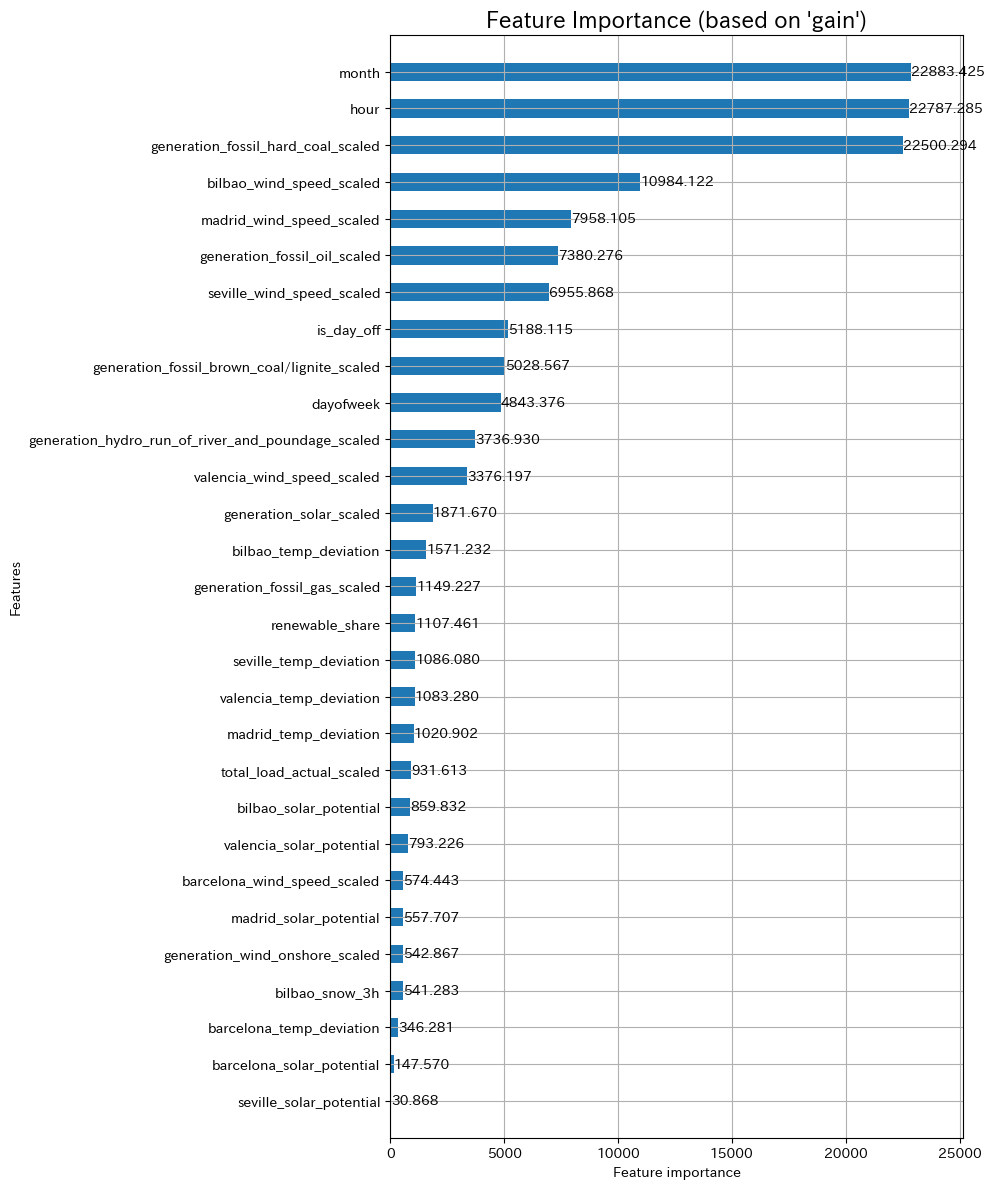

In [776]:
# --- 特徴量重要度の可視化 ---

# グラフのサイズを調整
plt.figure(figsize=(10, 12))

# LightGBMに組み込まれている関数で、特徴量重要度をプロット
lgb.plot_importance(
    model_lgbm,
    height=0.5,         # バーの高さ
    figsize=(10, 12),     # グラフのサイズ
    importance_type='gain' # ★重要度の種類を 'gain' に指定
)

plt.title("Feature Importance (based on 'gain')", fontsize=16)
plt.tight_layout() # レイアウトを自動調整
plt.show()


In [777]:
# --- 特徴量重要度の取得（修正版） ---

# .feature_importances_ は属性なので、() をつけずに呼び出す
# importance_typeはモデル初期化時に指定済み
feature_importance_df = pd.DataFrame({
    'feature': model_lgbm.feature_name_,
    'importance': model_lgbm.feature_importances_, # ← () を削除
}).sort_values('importance', ascending=False) # 重要度で並べ替え

# 全ての行を表示する設定
pd.set_option('display.max_rows', None)

print(f"--- 全特徴量の重要度 (importance_type='{model_lgbm.importance_type}') ---")
print(feature_importance_df)

# 設定を元に戻す
pd.reset_option('display.max_rows')


# もし、gainとsplitの両方を見たい場合は、モデルを2つ学習させるか、
# 一度学習させた後で、モデルの属性を書き換える必要があります。
# (ただし、通常はどちらか一方の指標で評価します)

# 例：splitの重要度も取得する場合
model_lgbm.importance_type = 'split' # ここで属性を書き換える
feature_importance_df['importance_split'] = model_lgbm.feature_importances_

--- 全特徴量の重要度 (importance_type='split') ---
                                              feature  importance
26                                              month         184
24                                               hour         175
16                           bilbao_wind_speed_scaled         133
18                          seville_wind_speed_scaled          90
11                 generation_fossil_hard_coal_scaled          87
14                           madrid_wind_speed_scaled          77
13        generation_fossil_brown_coal/lignite_scaled          65
9   generation_hydro_run_of_river_and_poundage_scaled          65
25                                          dayofweek          55
32                                         is_day_off          42
12                       generation_fossil_oil_scaled          42
15                         valencia_wind_speed_scaled          39
7                             generation_solar_scaled          28
21                              b

Holdout RMSE記録用


*   最初のベースライン（LightGBM）: 11.277
*   6/7（dayofweekなど追加）: 10.694
*   6/7（気温の偏差を追加）：10.935
*6/7 22:17（休日フラグ列を追加+early_stopping追加）：10.588
*6/8 solar_potentialとrenewable_shareはなし：10.390
* 6/9 solar_potentialを追加：10.488
* 6/9 generation_fossil_brown_coal/ligniteを追加：10.256



xgboostを試す

In [778]:
# # ライブラリを最新版にアップグレードする
# !pip install --upgrade xgboost

In [779]:
# import xgboost as xgb
# # 他のライブラリ（pandas, sklearnなど）は既にインポート済みとします

# # --- XGBoostのためのデータ準備 (カテゴリ変数の型変換) ---
# # XGBoostにカテゴリ変数を正しく認識させるため、事前にデータ型を 'category' に変更します。
# categorical_cols = ['is_day_off', "hour", "month"]

# # .copy() を使って SettingWithCopyWarning を回避
# X_train = X_train.copy()
# X_val = X_val.copy()
# # X_test も同様に
# # X_test = X_test.copy()

# for col in categorical_cols:
#     X_train[col] = X_train[col].astype('category')
#     X_val[col] = X_val[col].astype('category')
#     # X_test[col] = X_test[col].astype('category')


# # 1. XGBoostモデルの初期化
# # ★★★ eval_metric を .fit() からこちらに移動します ★★★
# model_xgb = xgb.XGBRegressor(
#     objective='reg:absoluteerror',  # LightGBMの 'regression_l1' (MAE) に相当
#     random_state=42,
#     n_estimators=100,              # 木の数の上限
#     learning_rate=0.05,
#     enable_categorical=True,        # カテゴリ変数を有効にする設定
#     eval_metric='rmse'              # ← ここで評価指標を指定
# )

# # 2. モデルの学習
# print("Training XGBoost")
# model_xgb.fit(
#     X_train,
#     y_train,
#     eval_set=[(X_val, y_val)],
#     # # eval_metric='rmse',         # ← ここからは削除
#     # early_stopping_rounds=50,       # 50回連続でスコアが改善しなければ停止
#     verbose=True                    # 学習の過程を表示
# )
# print("XGBoost model trained.")

Trainデータ全てを使用して再学習

In [780]:
# CVで見つけた最適な学習回数を使うのがベストプラクティス
# ここでは例として、CVでの平均best_iterationが350だったと仮定
# （実際には各Foldのmodel.best_iteration_を記録して平均を取る）
best_n_estimators = 1000 # 仮

# 最適なパラメータで最終モデルを初期化
final_model = lgb.LGBMRegressor(
    objective='regression_l1',
    random_state=42,
    n_estimators=best_n_estimators, # CVで見つけた回数を指定
    # learning_rateなど、チューニングした他のパラメータも設定
)

# train_dfの全データを使って学習（早期停止は不要）
final_model.fit(X, y, categorical_feature=categorical_features)
print("Final model trained.")

# --- 5. 最終的なテストデータに対する予測の作成 ---
all_train_data_final_test_predictions = final_model.predict(X_test)

print("\n最終的なテストデータへの予測値（最初の5件）:")
print(all_train_data_final_test_predictions[:5])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5342
[LightGBM] [Info] Number of data points in the train set: 26280, number of used features: 29
[LightGBM] [Info] Start training from score 55.930000
Final model trained.

最終的なテストデータへの予測値（最初の5件）:
[38.69599828 37.80741665 39.9047176  39.94463458 34.33589553]


# テストデータ予測と提出
- テストデータに対する予測
- 提出ファイルの作成

In [781]:
# y_test_pred = model_lgbm.predict(X_test)

In [782]:
# sample_submission に書き込み & 保存
# sample_submission_df[1] = y_test_pred

In [783]:
sample_submission_df[1] = all_train_data_final_test_predictions

In [784]:
sample_submission_df

,0,1
0,2018-01-01 00:00:00+01:00,38.695998
1,2018-01-01 01:00:00+01:00,37.807417
2,2018-01-01 02:00:00+01:00,39.904718
3,2018-01-01 03:00:00+01:00,39.944635
4,2018-01-01 04:00:00+01:00,34.335896
...,...,...
8755,2018-12-31 19:00:00+01:00,79.594381
8756,2018-12-31 20:00:00+01:00,79.041086
8757,2018-12-31 21:00:00+01:00,75.213543
8758,2018-12-31 22:00:00+01:00,71.361349


In [785]:
sample_submission_df.to_csv(submission_path+'cross_validation_0609_21:35.csv', header=False, index=False)